In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('fivethirtyeight')
import matplotlib_inline
from pathlib import Path
# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
import seaborn as sns
import datetime

# Questions
## Metadata
- `Date`: Is it a holiday? Do holidays have a greater attendance?
- `DayofWeek`: Is there greater attendance on weekends? Any particular day?
- `DayNight`: Do night games have greater attendance? Is there a best time? Could traffic be affecting this?
- `VistingTeamScore` and `HomeTeamScore`: Would average margin of victory/loss affect attendance?
- `VisitingTeamGameNumber`: Is early in the season, middle, or end have greater attendance?
- `HomeTeamGameNumber`: Is early in the season, middle, or end have greater attendance? Before or after all-star break?
- `NumberofOuts` and `LengthofGame`: How does length of game (min) and length of game in outs affect attendance? Do shorter games have longer attendance?
- `Park ID` does average temperature/climate of park affect attendance?

## Derived Features
- `Visiting team ranking` (find feature) effect on attendance?
- `Home team ranking` (find feature) effect on attendance?
- `VisitingTeam_StartingPitcher_Name` is all-star?
- `HomeTeam_StartingPitcher_Name` is all-star?
- How does number of all-stars affect attendance?
- How does average age of starting lineup affect attendance?
    - Try using `HomeTeam_Player_#_Name` and `VisitingTeam_Player_#_Name`

## Game Stats
- Visiting team offensive statistics?
- Visiting team pitching statistics?
- Visiting team defensive statistics?
- Home team offensive statistics?
- Home team pitching statistics?
- Home team defensive statistics?

In [2]:
DATA_PATH = Path('../../data')

In [3]:
df_features = pd.read_parquet(DATA_PATH.joinpath('processed', 'game_logs_standings.parquet'))

In [22]:
df_features.columns.tolist()

['Gm#',
 'Year',
 'Date',
 'Unnamed: 3',
 'Tm',
 'Unnamed: 5',
 'Opp',
 'W/L',
 'R',
 'RA',
 'Inn',
 'W-L',
 'HomeTeam_Rank',
 'GB',
 'Win',
 'Loss',
 'Save',
 'Time',
 'D/N',
 'Attendance_TRUTH_x',
 'HomeTeam_cLI',
 'Streak',
 'Orig. Scheduled',
 'At',
 'VisitingTeam',
 'HomeTeam',
 'HomeTeam_W',
 'HomeTeam_L',
 'HomeTeam_Streak_count',
 'VisitingTeam_W',
 'VisitingTeam_L',
 'VisitingTeam_Rank',
 'VisitingTeam_cLI',
 'VisitingTeam_Streak_count',
 'Attendance_TRUTH_y',
 'NumberofGames',
 'DayofWeek',
 'VisitingTeamLeague',
 'VisitingTeamGameNumber',
 'HomeTeamLeague',
 'HomeTeamGameNumber',
 'VistingTeamScore',
 'HomeTeamScore',
 'NumberofOuts',
 'DayNight',
 'BallParkID',
 'Attendance',
 'LengthofGame',
 'VisitingTeam_LineScore',
 'HomeTeam_LineScore',
 'VisitingTeamOffense_AtBats',
 'VisitingTeamOffense_Hits',
 'VisitingTeamOffense_Doubles',
 'VisitingTeamOffense_Triples',
 'VisitingTeamOffense_Homeruns',
 'VisitingTeamOffense_RBIs',
 'VisitingTeamOffense_SacrificeHits',
 'VisitingTe

avg_attendance_1_yr_ago          0.665598
avg_attendance_2_yr_ago          0.586072
avg_attendance_3_yr_ago          0.526415
Stadium_Capacity                 0.337732
HomeTeam_Rank                    0.325703
HomeTeam_cLI                     0.244058
Dayofweek                        0.237023
HomeTeam_W                       0.162483
W                                0.162483
HomeTeamLeague                   0.141373
HomeTeam_Player9_Position        0.117263
VisitingTeam_Player9_Position    0.111517
VisitingTeamLeague               0.111451
DayNight                         0.110524
Streak_count                     0.078372
HomeTeam_Streak_count            0.078372
VisitingTeam_W                   0.071994
HomeTeam_StartingPitcher_ID      0.065847
VisitingTeam_cLI                 0.064453
Dayofyear                        0.062540
Name: Attendance_TRUTH_y, dtype: float64

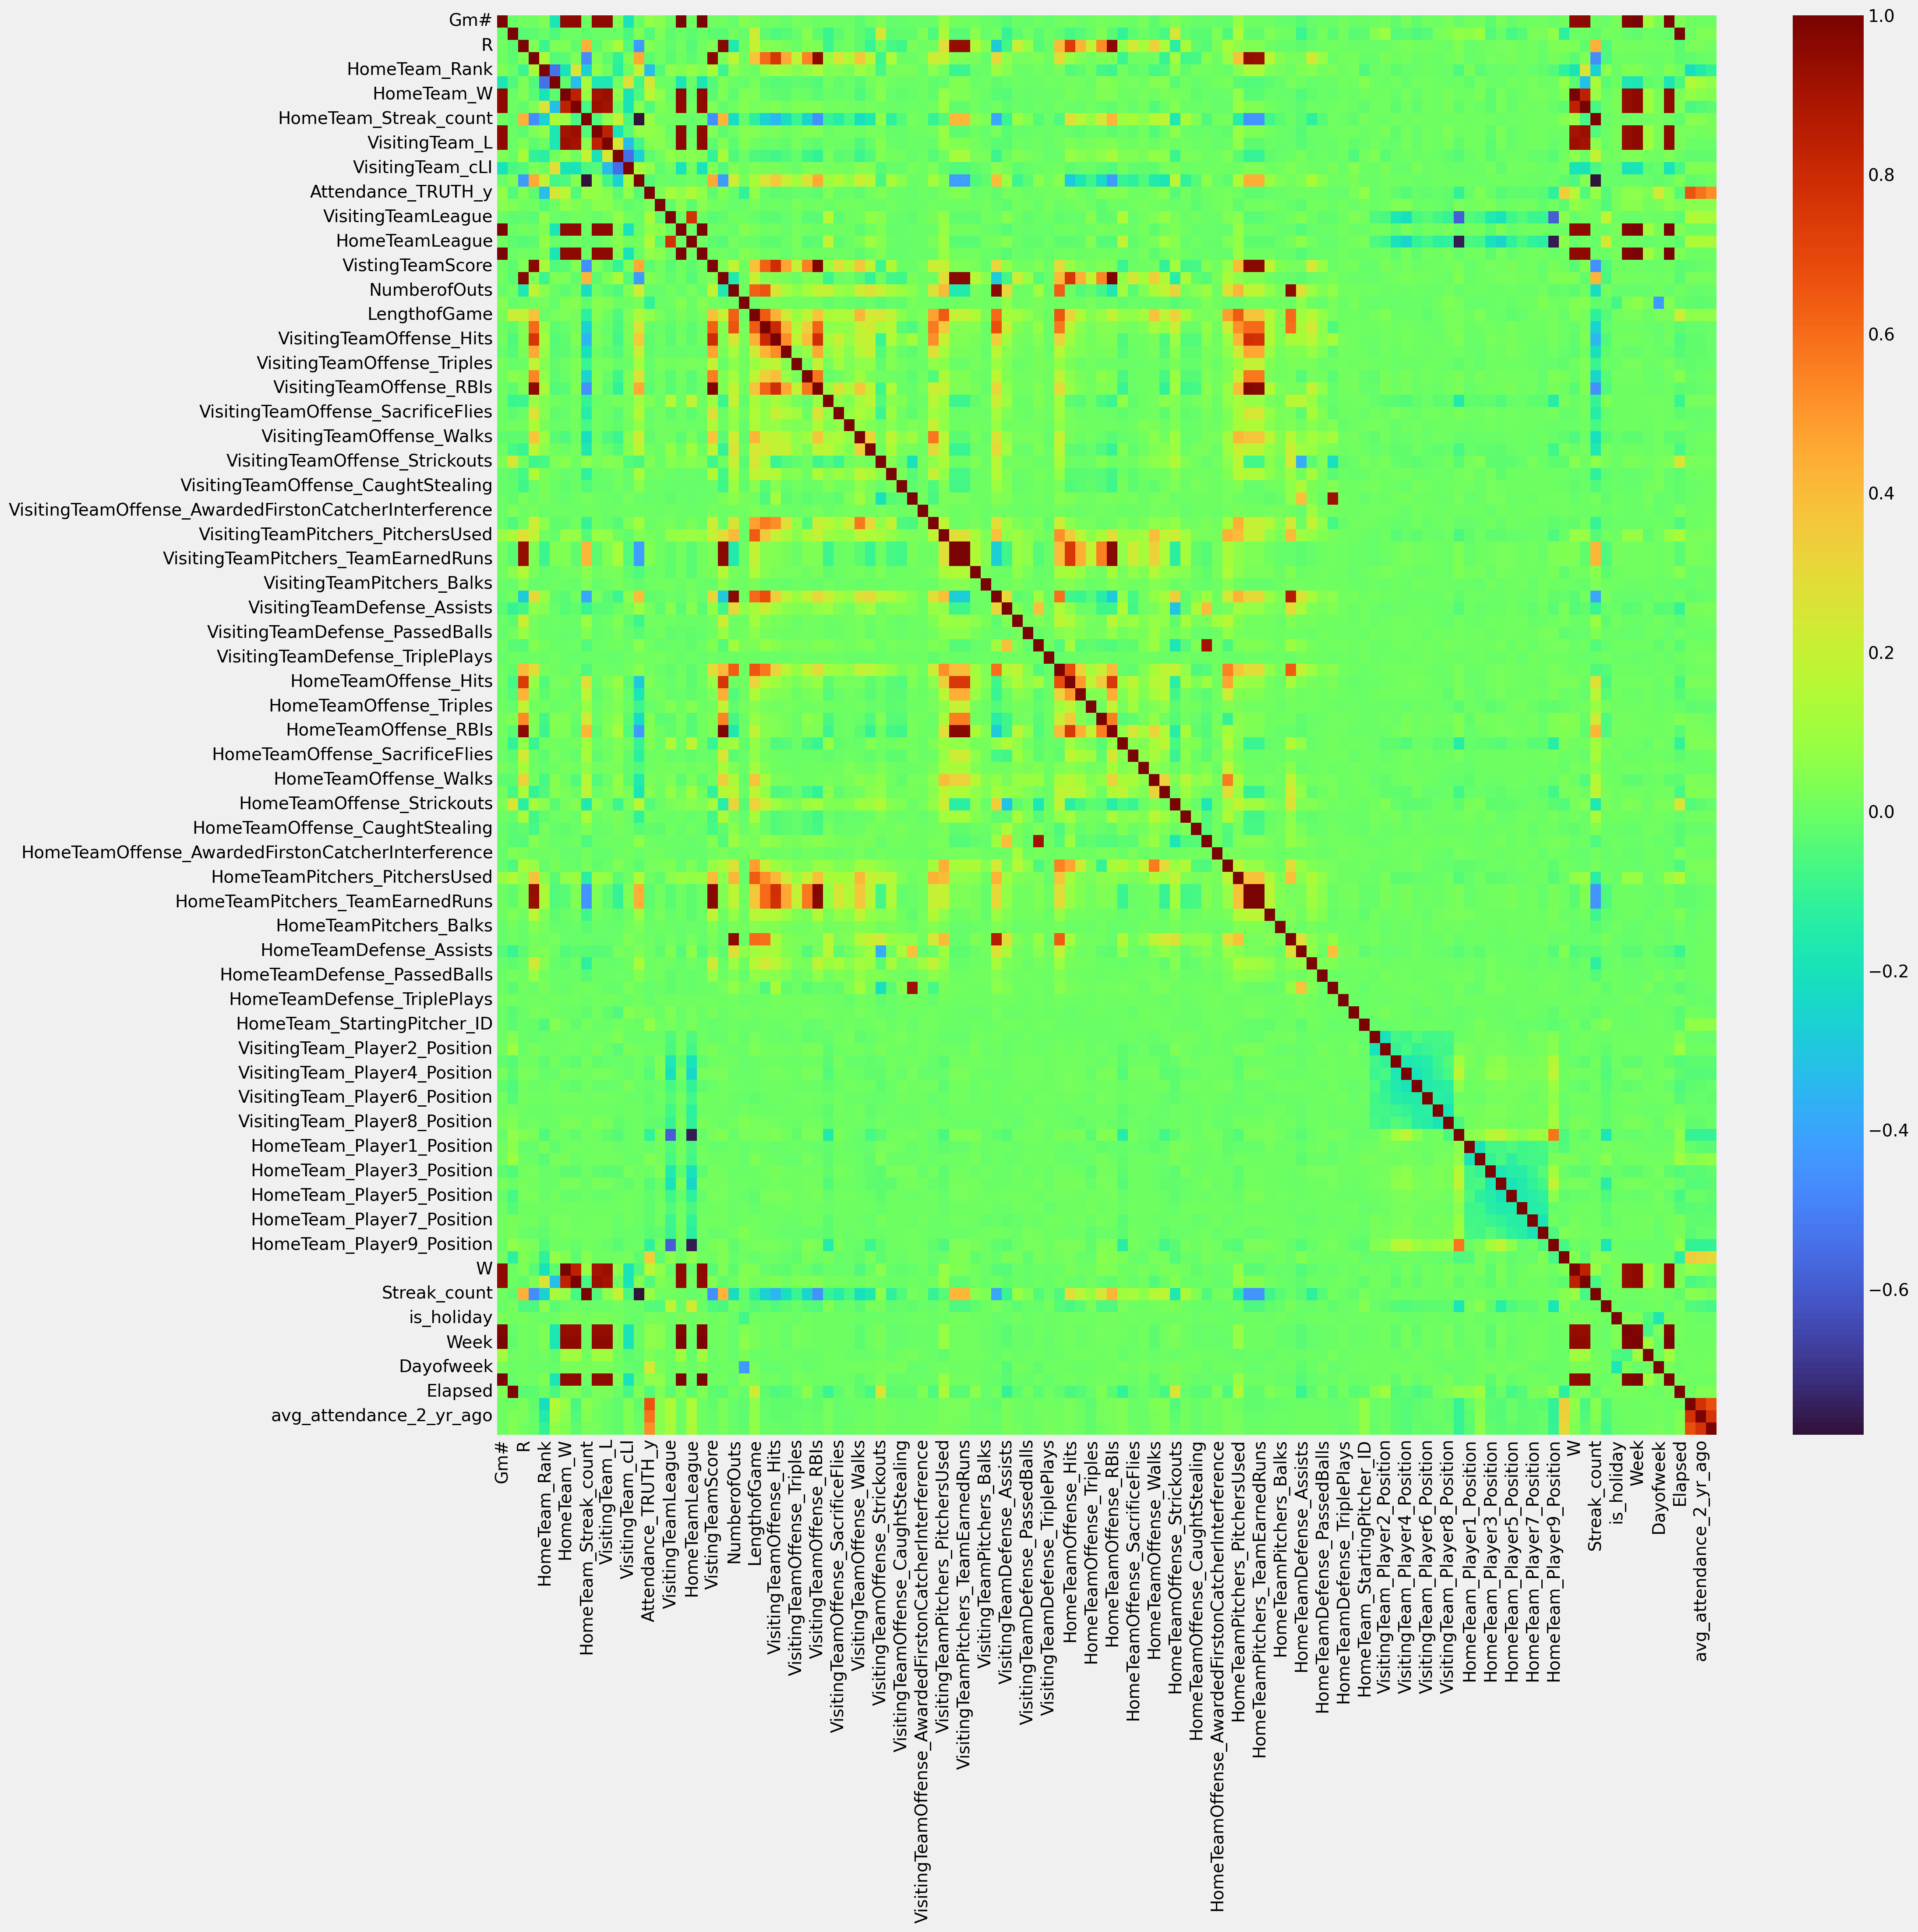

In [4]:
# pearson correlations
corr = df_features.select_dtypes(['int', 'float']).corr(method='pearson')
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(corr, cmap='turbo', ax=ax)
# filter by top 20 strongest pearson correlations with attendance excluding attendance with itself
display(corr.loc[corr.index != 'Attendance_TRUTH_y', 'Attendance_TRUTH_y'].abs().sort_values(ascending=False).iloc[:20])

In [37]:
p_correlated_features = corr.loc[corr.index != 'Attendance_TRUTH_y', 'Attendance_TRUTH_y'] \
                          .abs().sort_values(ascending=False).iloc[:20].index.to_numpy()
p_correlated_features

array(['avg_attendance_1_yr_ago', 'avg_attendance_2_yr_ago',
       'avg_attendance_3_yr_ago', 'Stadium_Capacity', 'HomeTeam_Rank',
       'HomeTeam_cLI', 'HomeTeam_W', 'W', 'HomeTeamLeague',
       'HomeTeam_Player9_Position', 'VisitingTeam_Player9_Position',
       'VisitingTeamLeague', 'DayNight', 'Streak_count',
       'HomeTeam_Streak_count', 'VisitingTeam_W',
       'HomeTeam_StartingPitcher_ID', 'VisitingTeam_cLI', 'LengthofGame',
       'VisitingTeamGameNumber'], dtype=object)

<Axes: >

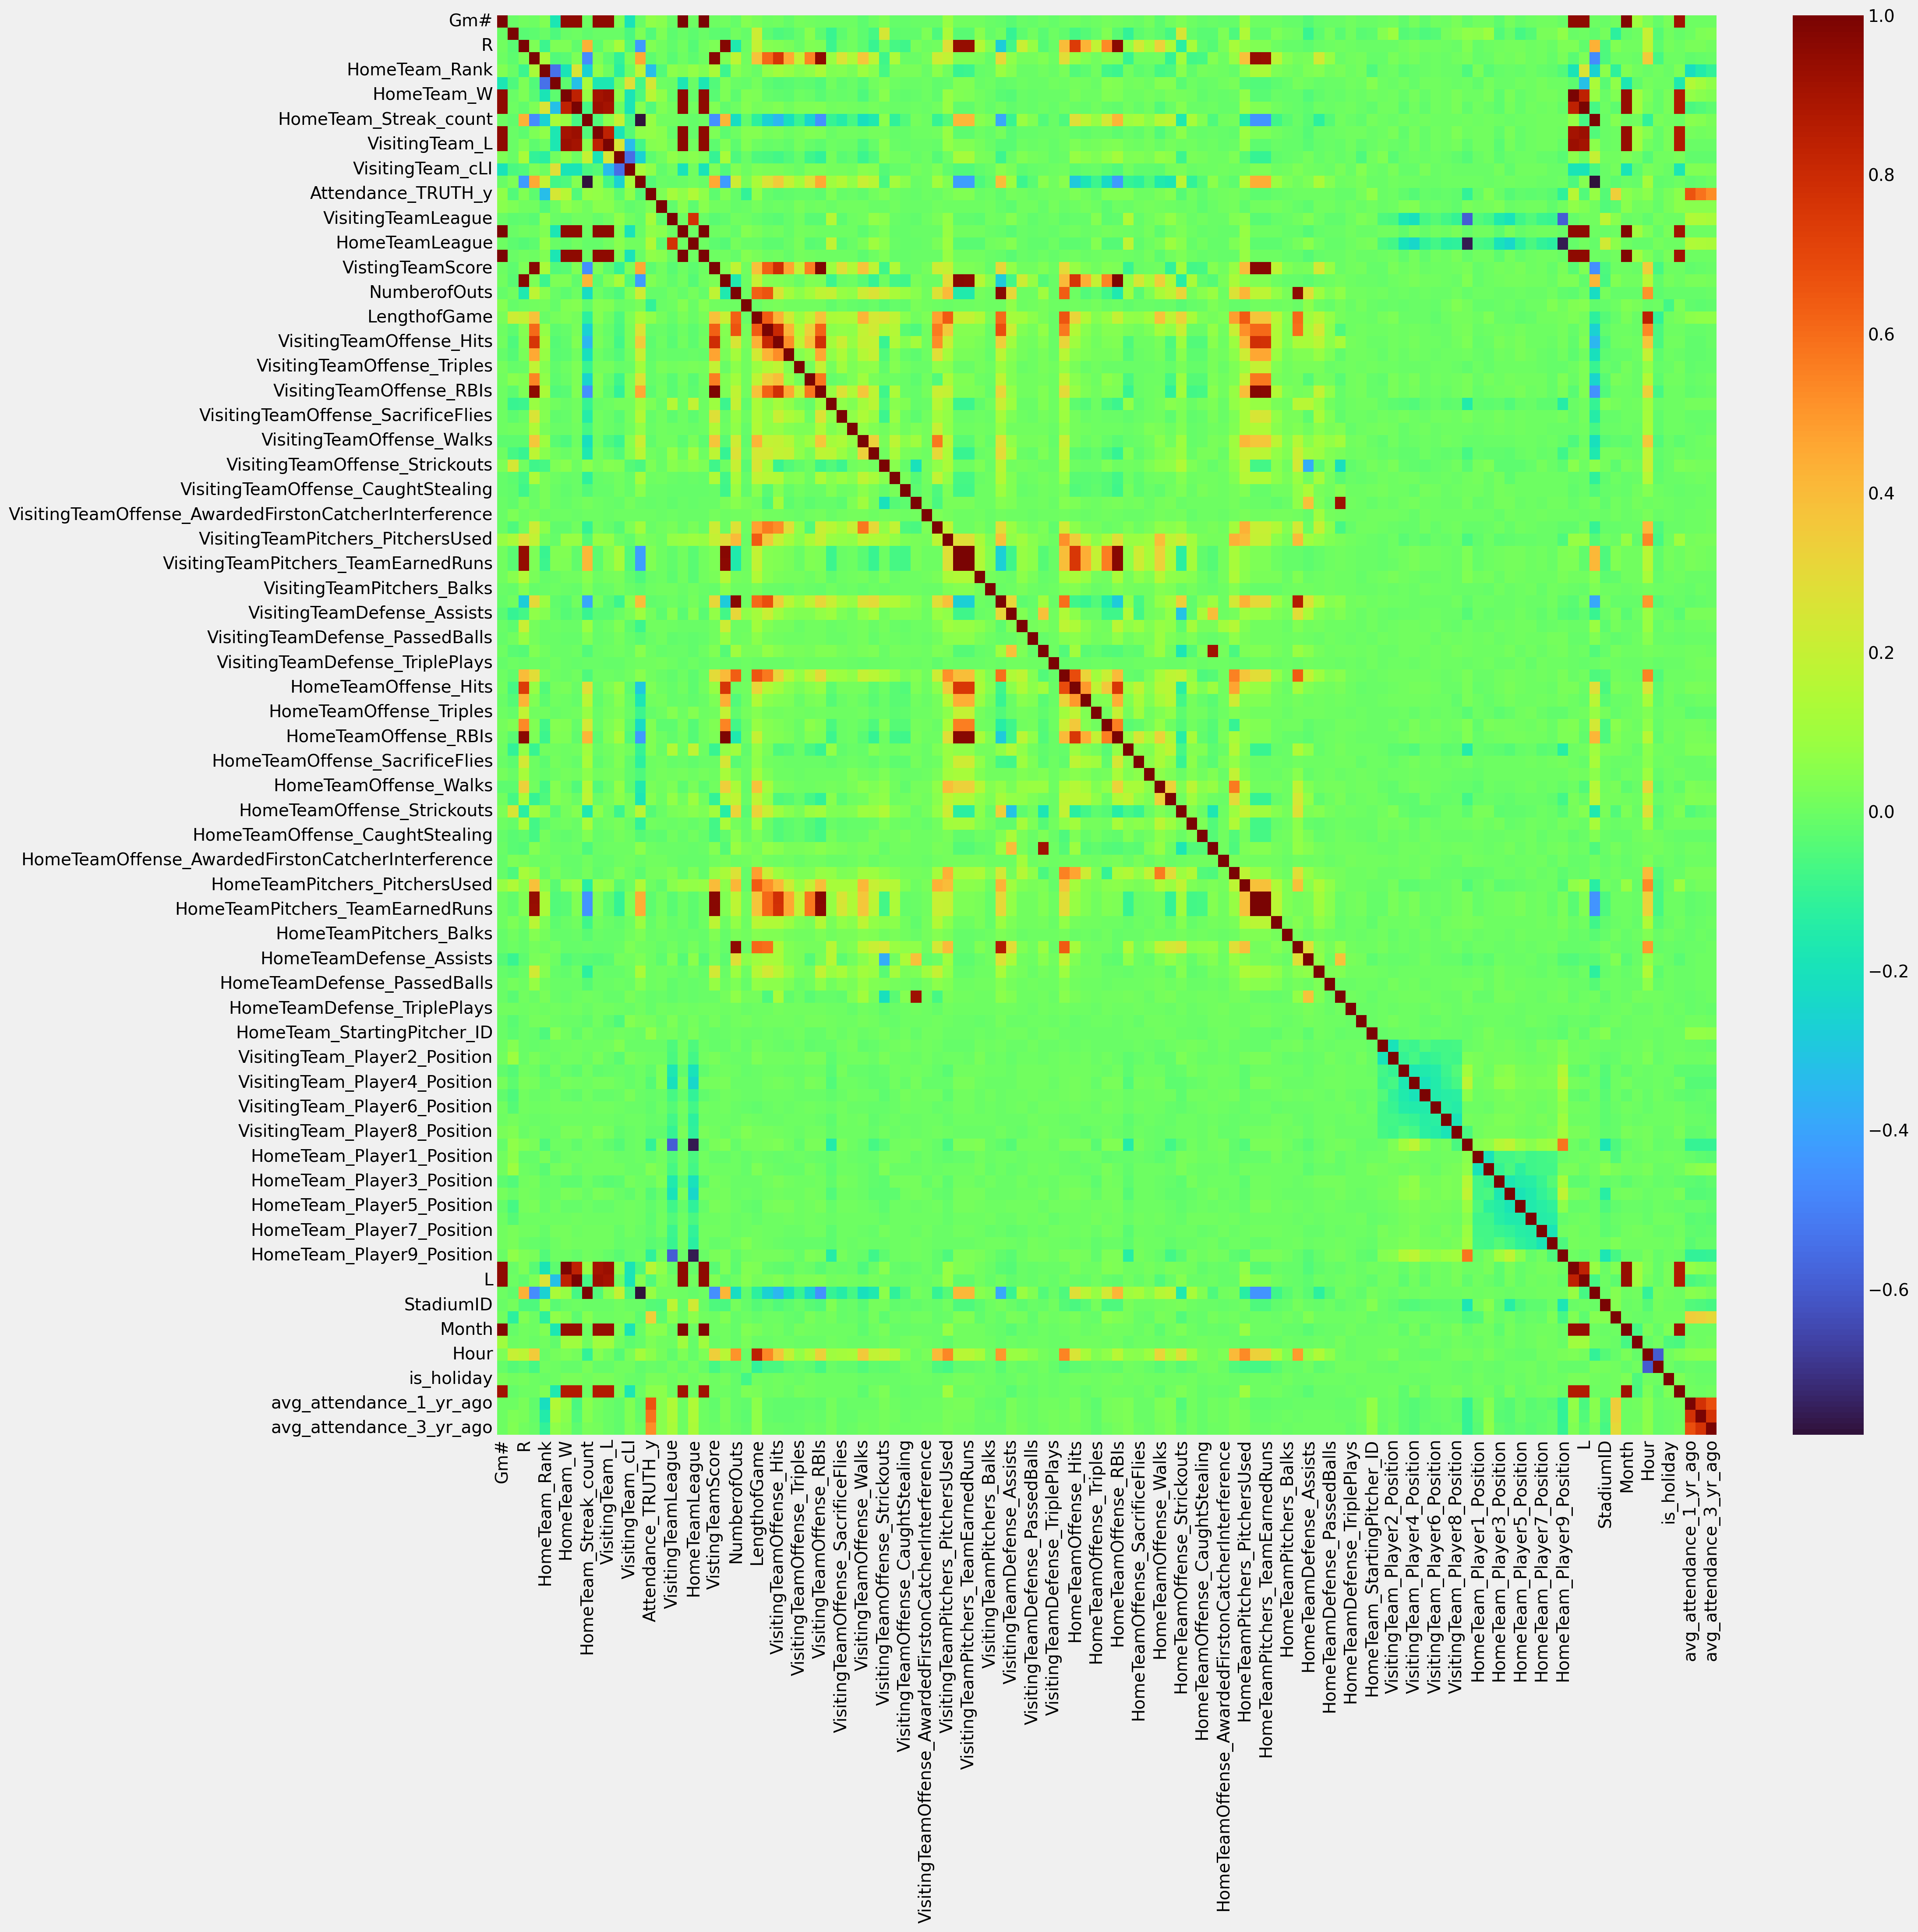

In [38]:
corr = df_features.select_dtypes(['int', 'float']).corr(method='pearson')
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(corr, cmap='turbo', ax=ax)

In [18]:
df_features['HomeTeam_Player9_Position'].max()

10

In [20]:
df_features['VisitingTeam_Player9_Position'].min()

1

avg_attendance_1_yr_ago          0.657068
avg_attendance_2_yr_ago          0.576021
avg_attendance_3_yr_ago          0.516988
HomeTeam_Rank                    0.326768
Stadium_Capacity                 0.310640
HomeTeam_cLI                     0.264513
HomeTeam_W                       0.153454
W                                0.153454
HomeTeamLeague                   0.145489
HomeTeam_Player9_Position        0.132838
VisitingTeam_Player9_Position    0.130816
VisitingTeamLeague               0.113882
DayNight                         0.109184
VisitingTeam_W                   0.071753
HomeTeam_Streak_count            0.067507
Streak_count                     0.067507
HomeTeam_StartingPitcher_ID      0.067420
LengthofGame                     0.062080
VisitingTeamGameNumber           0.058067
season                           0.057942
Name: Attendance_TRUTH_y, dtype: float64

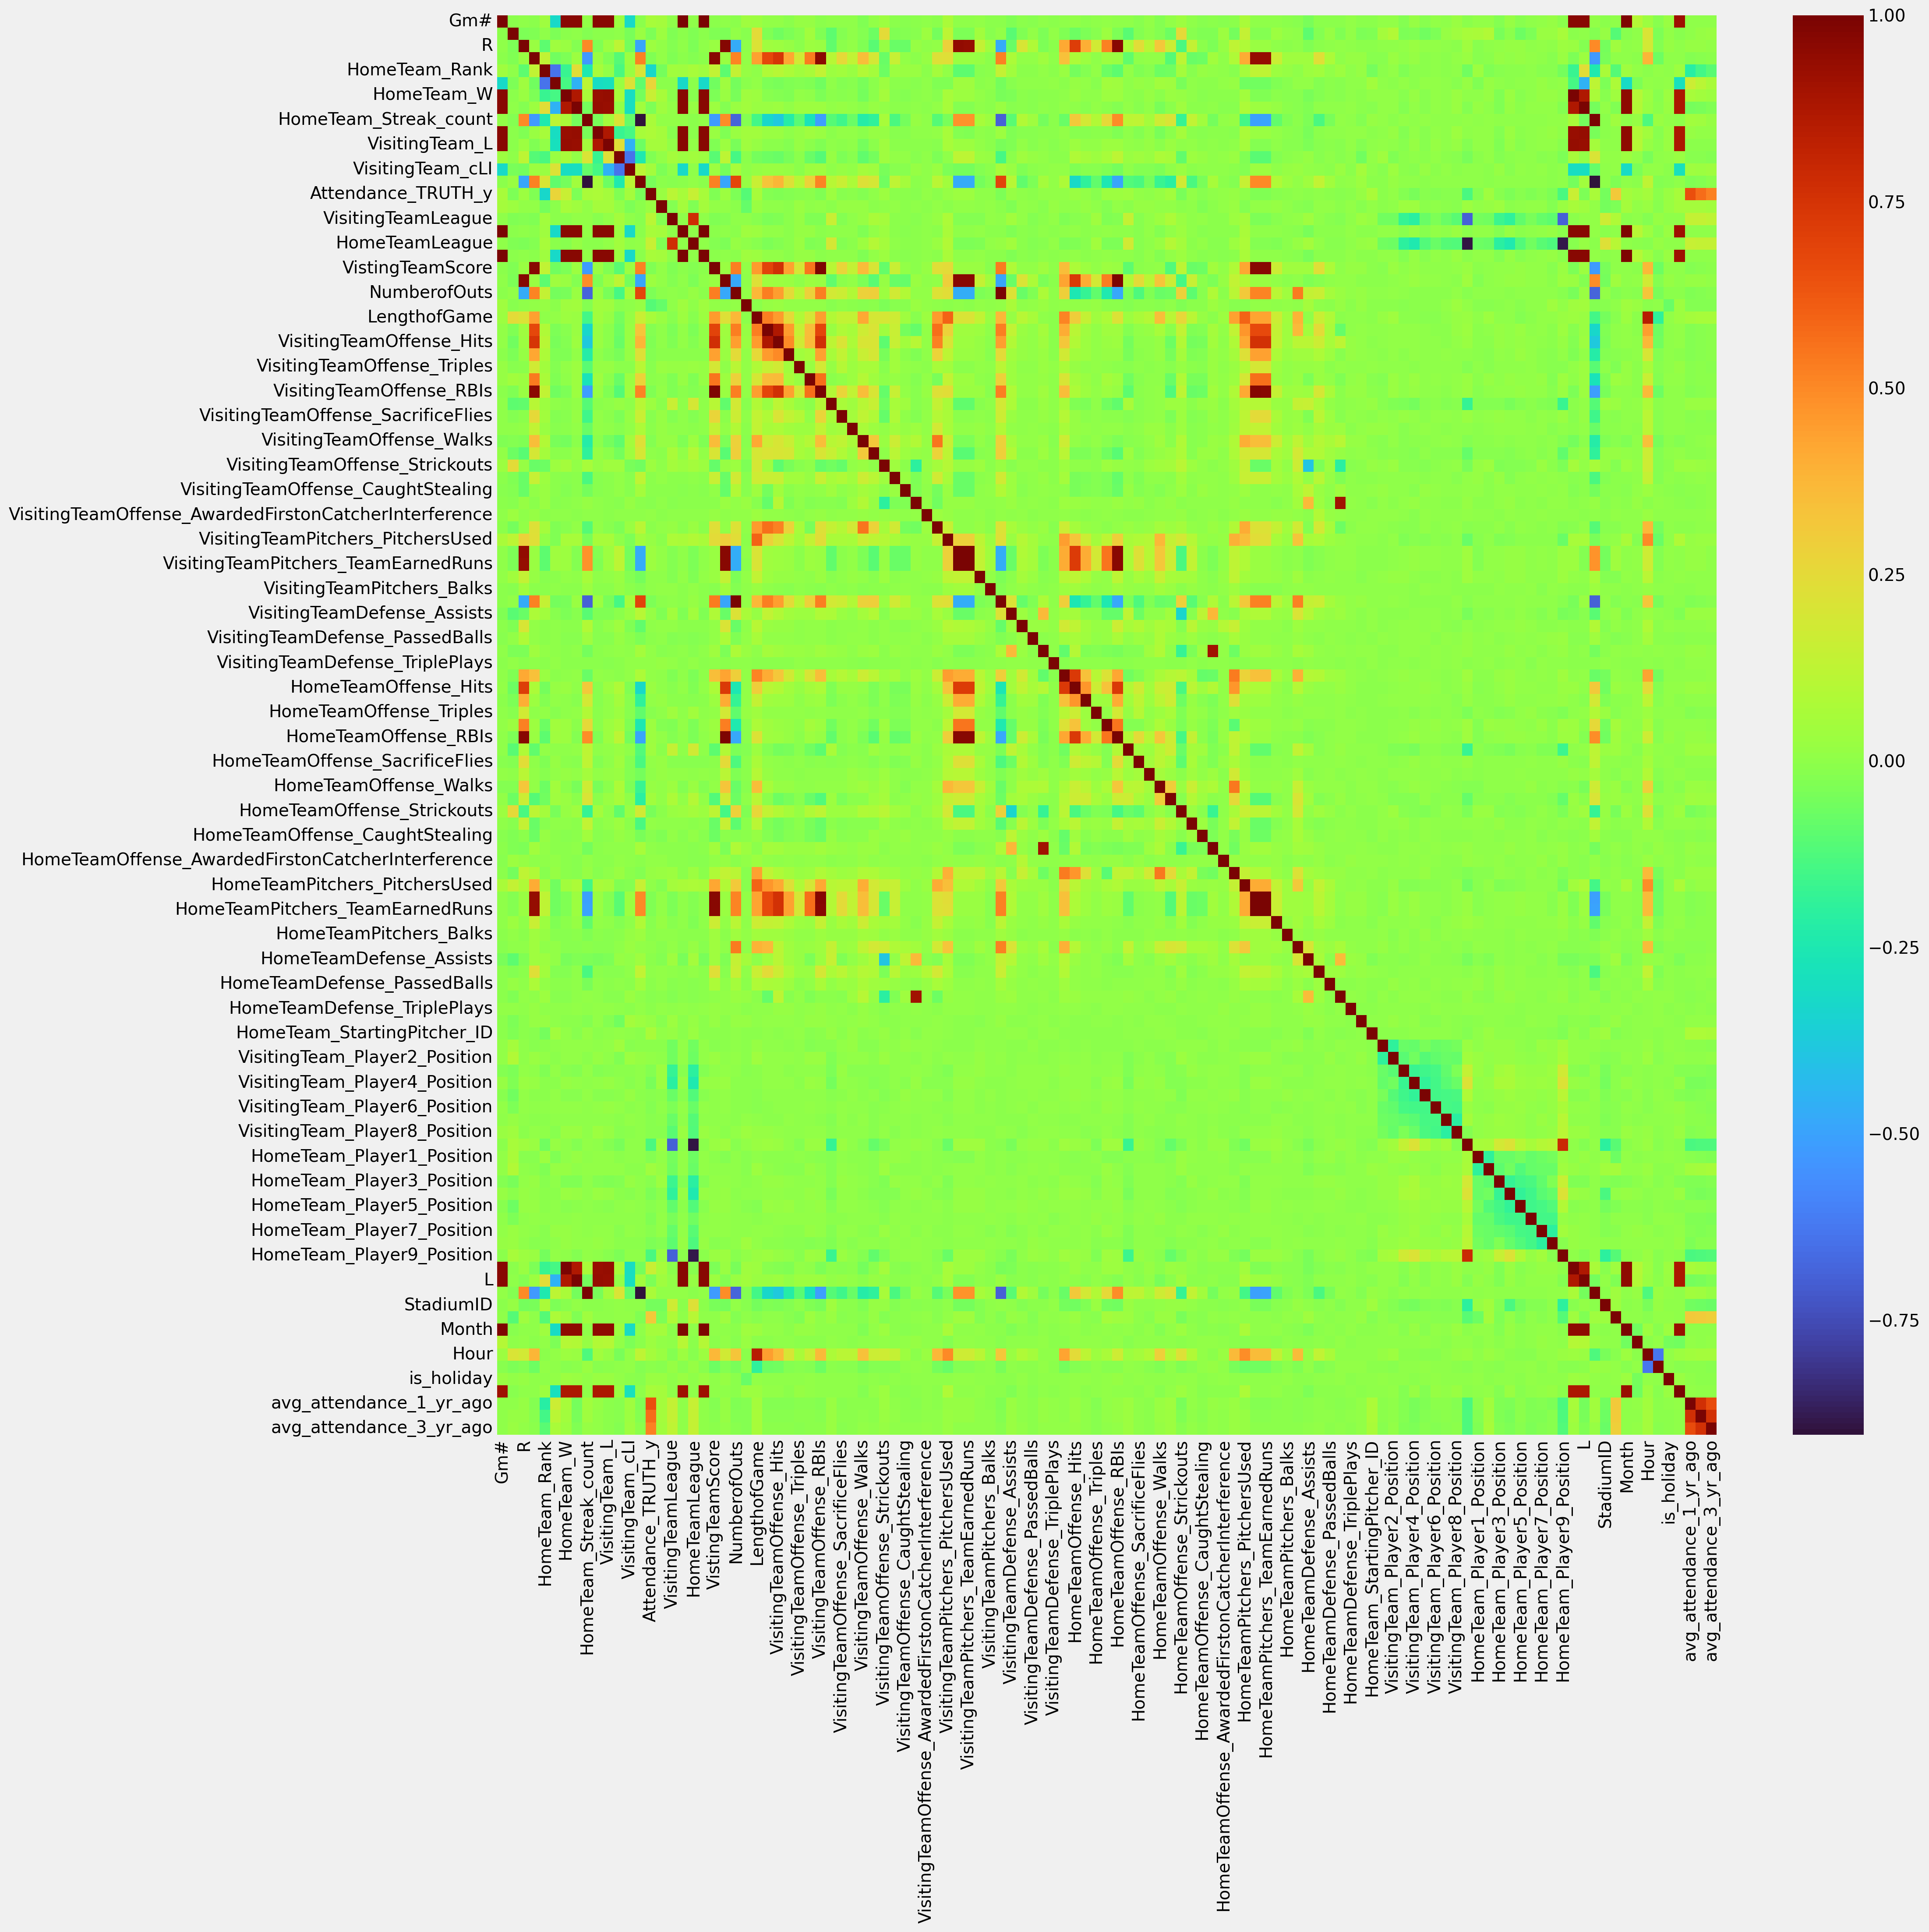

In [39]:
# spearman correlations - monotonic relationships
corr = df_features.select_dtypes(['int', 'float']).corr(method='spearman')
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(corr, cmap='turbo', ax=ax)
# filter by top 20 strongest pearson correlations with attendance excluding attendance with itself
display(corr.loc[corr.index != 'Attendance_TRUTH_y', 'Attendance_TRUTH_y'].abs().sort_values(ascending=False).iloc[:20])

In [40]:
s_correlated_features = corr.loc[corr.index != 'Attendance_TRUTH_y', 'Attendance_TRUTH_y'] \
                          .abs().sort_values(ascending=False).iloc[:20].index.to_numpy()
s_correlated_features

array(['avg_attendance_1_yr_ago', 'avg_attendance_2_yr_ago',
       'avg_attendance_3_yr_ago', 'HomeTeam_Rank', 'Stadium_Capacity',
       'HomeTeam_cLI', 'HomeTeam_W', 'W', 'HomeTeamLeague',
       'HomeTeam_Player9_Position', 'VisitingTeam_Player9_Position',
       'VisitingTeamLeague', 'DayNight', 'VisitingTeam_W',
       'HomeTeam_Streak_count', 'Streak_count',
       'HomeTeam_StartingPitcher_ID', 'LengthofGame',
       'VisitingTeamGameNumber', 'season'], dtype=object)

In [41]:
# find intersection of pearson and spearman correlations for linear regression features
p = set(p_correlated_features)
s = set(s_correlated_features)
features = list(p.intersection(s))
features = np.array(features)

In [42]:
features

array(['avg_attendance_2_yr_ago', 'VisitingTeam_W',
       'HomeTeam_Streak_count', 'VisitingTeamLeague',
       'avg_attendance_1_yr_ago', 'HomeTeam_Player9_Position', 'DayNight',
       'LengthofGame', 'VisitingTeamGameNumber', 'HomeTeam_cLI',
       'Stadium_Capacity', 'HomeTeam_W', 'HomeTeam_StartingPitcher_ID',
       'HomeTeamLeague', 'VisitingTeam_Player9_Position', 'Streak_count',
       'avg_attendance_3_yr_ago', 'W', 'HomeTeam_Rank'], dtype='<U29')

In [43]:
p_correlated_features

array(['avg_attendance_1_yr_ago', 'avg_attendance_2_yr_ago',
       'avg_attendance_3_yr_ago', 'Stadium_Capacity', 'HomeTeam_Rank',
       'HomeTeam_cLI', 'HomeTeam_W', 'W', 'HomeTeamLeague',
       'HomeTeam_Player9_Position', 'VisitingTeam_Player9_Position',
       'VisitingTeamLeague', 'DayNight', 'Streak_count',
       'HomeTeam_Streak_count', 'VisitingTeam_W',
       'HomeTeam_StartingPitcher_ID', 'VisitingTeam_cLI', 'LengthofGame',
       'VisitingTeamGameNumber'], dtype=object)